In [188]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from classification import compute_accuracy
from classification import KNN
from regression import compute_error, fill_in_missing_values
from regression import get_data, grid_search, unnormalize
from regression import LinearRegression, KNNRegression

pd.set_option('display.max_rows', 500)

%reload_ext autoreload
%autoreload 2
%matplotlib inline

# Task 0. Explore the dataset

In [189]:
data = pd.read_csv('./data/Mușat_F_Andreea_Alexandra_train.csv')

print('Number of data rows: {}'.format(len(data)))
print('Columns are: {}'.format(data.columns))

data.sample(n=5)

Number of data rows: 1000
Columns are: Index(['Breed Name', 'Weight(g)', 'Height(cm)', 'Longevity(yrs)',
       'Energy level', 'Attention Needs', 'Coat Lenght', 'Sex', 'Owner Name'],
      dtype='object')


,Breed Name,Weight(g),Height(cm),Longevity(yrs),Energy level,Attention Needs,Coat Lenght,Sex,Owner Name
762,Welsh Corgi,15766.5097,29.7739,11.0895,med,high,med,female,Williams
848,Rottweiler,42255.8068,66.7096,7.9534,med,med,short,female,Hebert
722,Welsh Corgi,16486.5938,27.4156,11.7787,med,high,med,female,Thomas
699,Airedale Terrier,20964.0085,56.2945,11.2414,high,high,med,male,Atkins
482,Rottweiler,54914.7597,64.5584,9.0872,med,high,short,male,Sherman


Let's inspect the breeds count distribution in our dataset:

Text(0.5, 1.0, 'Breeds distribution in dataset')

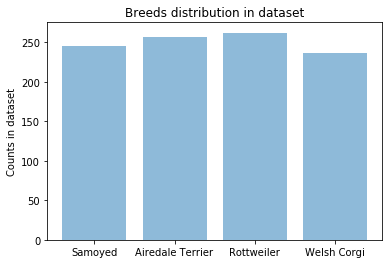

In [190]:
unique_breeds = data['Breed Name'].unique()
breed_count = np.zeros(len(unique_breeds))

for i in range(len(unique_breeds)):
    breed_count[i] = data[data['Breed Name'] == unique_breeds[i]]['Breed Name'].count()
    
plt.bar(unique_breeds, breed_count, align='center', alpha=0.5)
plt.ylabel('Counts in dataset')
plt.title('Breeds distribution in dataset')    

Let's replace the string values with numerical values:

In [191]:
for column_name in data.columns:
    if data[column_name].dtype == object:
        replace_map = {}
        unique_vals = data[column_name].unique()
        for i in range(len(unique_vals)):
            replace_map[unique_vals[i]] = i
        data[column_name] = data[column_name].map(replace_map)
        
data.sample(3)

,Breed Name,Weight(g),Height(cm),Longevity(yrs),Energy level,Attention Needs,Coat Lenght,Sex,Owner Name
46,3,10602.2893,27.2273,11.7008,0,0,1,0,44
895,0,17916.6723,53.7774,10.9131,0,0,1,1,9
298,2,50924.0667,61.8787,10.6707,0,0,0,1,158


In [192]:
missing_vals_cols = [col for col in data.columns if data[col].isnull().any()]
print(missing_vals_cols)

['Height(cm)']


We can fill in the missing values with the mean value of that column:

In [193]:
fill_in_missing_values(data, missing_vals_cols[0])

We inspect the correlation between our variables, as this might provide useful insights about our data:

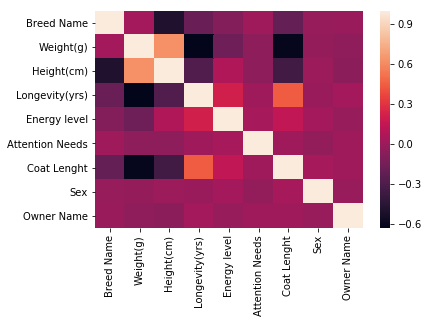

In [194]:
corr = pd.get_dummies(data).corr()
sns.heatmap(corr, 
        xticklabels=corr.columns,
        yticklabels=corr.columns)

We notice that there is a strong correlation between certain variables, such as Rottweiler and weight or terrier and high energy level, things that we'd expect to happen.

# Task 1. Classification

## Task 1.1 KNN classification

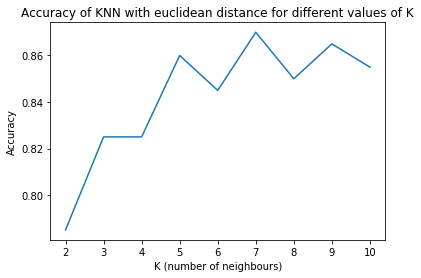

[0.785, 0.825, 0.825, 0.86, 0.845, 0.87, 0.85, 0.865, 0.855]


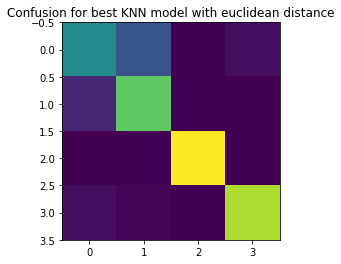

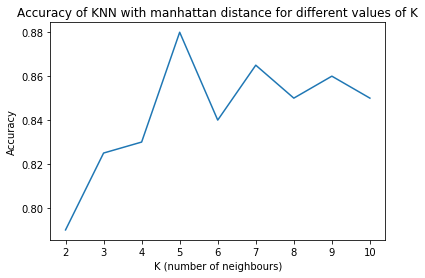

[0.79, 0.825, 0.83, 0.88, 0.84, 0.865, 0.85, 0.86, 0.85]


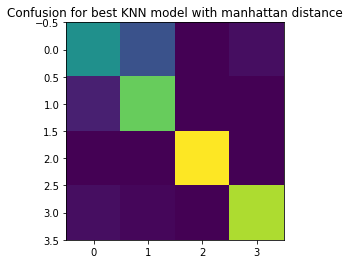

In [195]:
kLabel = 'Breed Name'    # This is the label we want to predict

X_train, y_train, X_test, y_test = get_data(
    data, kLabel, ['Longevity(yrs)'], 0.8)

# Grid search for the best hyperparameters
min_num_neigh, max_num_neigh = 2, 10
for dist_type in ['euclidean', 'manhattan']:
    best_model = {}
    accs = []
    for num_neighs in range(min_num_neigh, max_num_neigh + 1):
        knn = KNN(K=num_neighs, dist_type=dist_type)
        knn.fit(X_train, y_train)
        y_pred = knn.predict(X_test)
        acc, confusion_matrix = compute_accuracy(y_test, y_pred)
        accs.append(acc)
        if len(best_model) == 0 or acc > best_model['acc']:
            best_model['acc'] = acc
            best_model['model'] = knn
            best_model['confusion'] = confusion_matrix

    plt.plot(range(min_num_neigh, max_num_neigh+1), accs)
    plt.xlabel('K (number of neighbours)')
    plt.ylabel('Accuracy')
    title = 'Accuracy of KNN with ' + dist_type + \
        ' distance for different values of K'
    plt.title(title)
    plt.show()
    plt.clf()
    
    print(accs)

    plt.imshow(best_model['confusion'])
    title = 'Confusion for best KNN model with ' + dist_type + ' distance'
    plt.title(title)
    plt.show()

## Task 2.2 Logistic regression classification

We first normalize the data by subtracting the mean value and dividing by the standard deviation of the column:

In [196]:
# Store the means and standard deviations of the normalized columns to use them
# later to unnormalize the data.
means, stds = {}, {}
for column_name in ['Weight(g)', 'Height(cm)', 'Longevity(yrs)']:
    means[column_name] = data[column_name].mean()
    stds[column_name] = data[column_name].std()
    data[column_name] = (data[column_name] - means[column_name]) / stds[column_name]

Now we test the logistic regression model on the normalized data:

Accuracy: 0.915


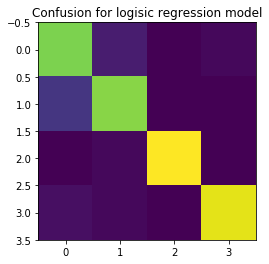

In [197]:
from sklearn.linear_model import LogisticRegression

X_train, y_train, X_test, y_test = get_data(
    data, kLabel, ['Longevity(yrs)', 'Owner Name'], 0.8)
log_regr = LogisticRegression(
    solver='lbfgs', multi_class='multinomial').fit(X_train, y_train.T[0])
y_pred = log_regr.predict(X_test)
acc, confusion_matrix = compute_accuracy(y_test, y_pred)
print('Accuracy: {}'.format(acc))
plt.imshow(confusion_matrix)
title = 'Confusion for logisic regression model'
plt.title(title)
plt.show()

## Task 2.3 Decision trees

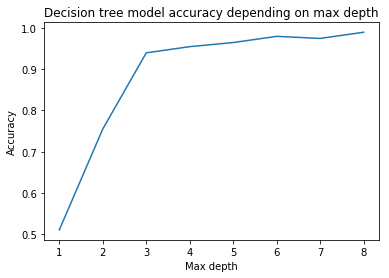

Accuracy: 0.99
Depth of the best model: 8


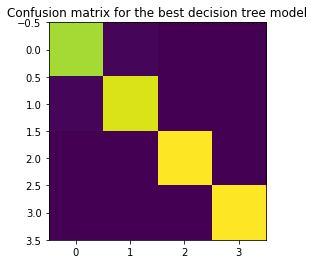

In [202]:
from sklearn import tree

best_min_model = {}
accs = []
for max_depth in range(1, len(data.columns)):
    clf = tree.DecisionTreeClassifier(max_depth=max_depth)
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    acc, confusion_matrix = compute_accuracy(y_test, y_pred)
    accs.append(acc)
    if len(best_min_model) == 0 or acc > best_min_model['acc']:
        best_min_model['acc'] = acc
        best_min_model['model'] = clf
        best_min_model['confusion'] = confusion_matrix
        best_min_model['depth'] = max_depth
    
plt.plot(range(1, len(data.columns)), accs)
plt.title('Decision tree model accuracy depending on max depth')
plt.xlabel('Max depth')
plt.ylabel('Accuracy')
plt.show()
plt.clf()

print('Accuracy: {}'.format(best_min_model['acc']))
print('Depth of the best model: {}'.format(best_min_model['depth']))
plt.imshow(best_min_model['confusion'])
title = 'Confusion matrix for the best decision tree model'
plt.title(title)
plt.show()

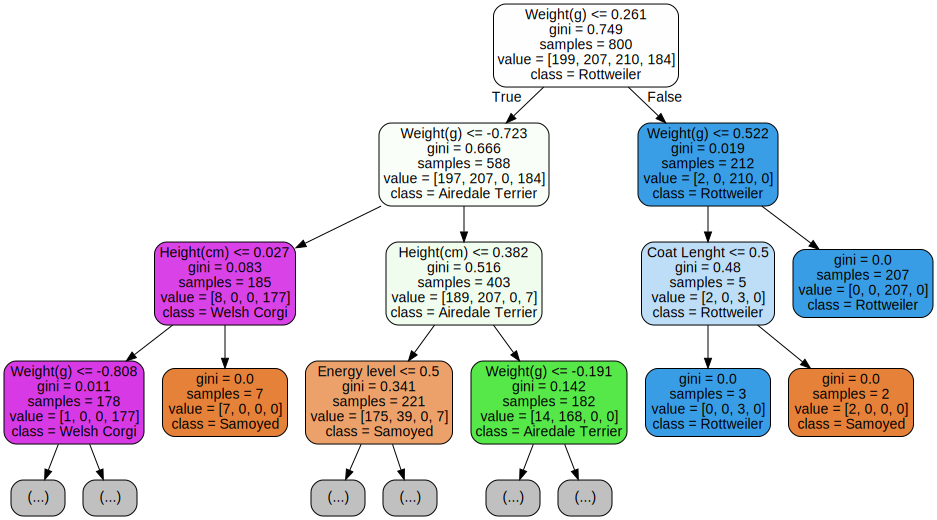

In [203]:
import graphviz
import matplotlib.image as mpimg

from graphviz import Source

dot_data = tree.export_graphviz(best_min_model['model'], out_file=None,
                                feature_names=['Weight(g)', 'Height(cm)', 'Energy level',
                                               'Attention Needs', 'Coat Lenght', 'Sex'],
                                class_names=unique_breeds,
                                filled=True, rounded=True,
                                max_depth=3)
graph = graphviz.Source(dot_data)
graph


## Task 1.4 Random forests

Accuracy of the best model: 0.955


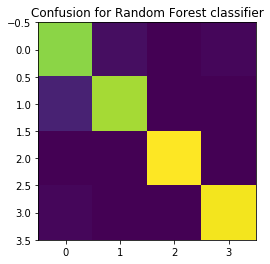

In [204]:
from sklearn.ensemble import RandomForestClassifier


clf = RandomForestClassifier(n_estimators=1000,
                             max_depth=3,
                             random_state=0)
clf.fit(X_train, y_train.T[0])
y_pred = clf.predict(X_test)
acc, confusion_matrix = compute_accuracy(y_test, y_pred)
print('Accuracy of the best model: {}'.format(acc))
plt.imshow(confusion_matrix)
title = 'Confusion for Random Forest classifier'
plt.title(title)
plt.show()

The best model for classification was the Decision Tree with depth 8 (all the columns).

The Random Forest model is not as precise, as we have used a maximum depth of 3 (as the aim of Random Forests is to reduce the maximum depth used for each tree in order to prevent overfitting).

In all the confusion matrices plotted it was visible that two of the breeds were quite similar, so the models were confusing them, thus resulting in misclassifications.

# Task 2. Regression

## Task 2.1. Linear regression

In [205]:
kLabel = 'Longevity(yrs)'
best_model = grid_search(data, kLabel, ['Breed Name', 'Owner Name'], means, stds, [None, 'ridge', 'lasso'], 
                         list(np.linspace(0.0001, 5, 10)), list(np.linspace(0.001, 0.2, 10)))

Train X shape:  (800, 6)
Train y shape:  (800, 1)
Test X shape:  (200, 6)
Test y shape:  (200, 1)
Best model is {'rms_err': 0.8846423485208625, 'sq_err': 78.25920847965072, 'reg': None, 'pen': 0.0001, 'lr': 0.001, 'model': <regression.LinearRegression object at 0x7f62403b59e8>, 'l1_err': 0.6865083517741126}
Best model is {'rms_err': 0.7845587671209738, 'sq_err': 61.553245906638246, 'reg': None, 'pen': 0.0001, 'lr': 0.023111111111111114, 'model': <regression.LinearRegression object at 0x7f62403b5080>, 'l1_err': 0.6239472836203825}
Best model is {'rms_err': 0.7801706293461289, 'sq_err': 60.86662108943348, 'reg': None, 'pen': 0.0001, 'lr': 0.06733333333333334, 'model': <regression.LinearRegression object at 0x7f62403b5780>, 'l1_err': 0.6199119659119764}
Best model is {'rms_err': 0.7735497818251499, 'sq_err': 59.837926496173694, 'reg': None, 'pen': 0.0001, 'lr': 0.13366666666666668, 'model': <regression.LinearRegression object at 0x7f62403b5080>, 'l1_err': 0.6132149033824317}


In [206]:
print('Best model squared error: {}'.format(best_model['sq_err']))
print('Best model RMS error: {}'.format(best_model['rms_err']))
print('Best model L1 error: {}'.format(best_model['l1_err']))

Best model squared error: 59.837926496173694
Best model RMS error: 0.7735497818251499
Best model L1 error: 0.6132149033824317


We can also try to use polynomial features to see if they improve the result:

Regression with polynomial features (deg=2) squared error: 48.601762522051004
Regression with polynomial features (deg=2) rms error: 0.6971496433481911
Regression with polynomial features (deg=2) L1 error: 0.5127321158595288
Regression with polynomial features (deg=3) squared error: 31.82096118169295
Regression with polynomial features (deg=3) rms error: 0.5641007107041521
Regression with polynomial features (deg=3) L1 error: 0.3630417060508546
Regression with polynomial features (deg=4) squared error: 528.1287319636685
Regression with polynomial features (deg=4) rms error: 2.2981051585244496
Regression with polynomial features (deg=4) L1 error: 0.6274953547378979
31.82096118169295
0.5641007107041521
0.3630417060508546


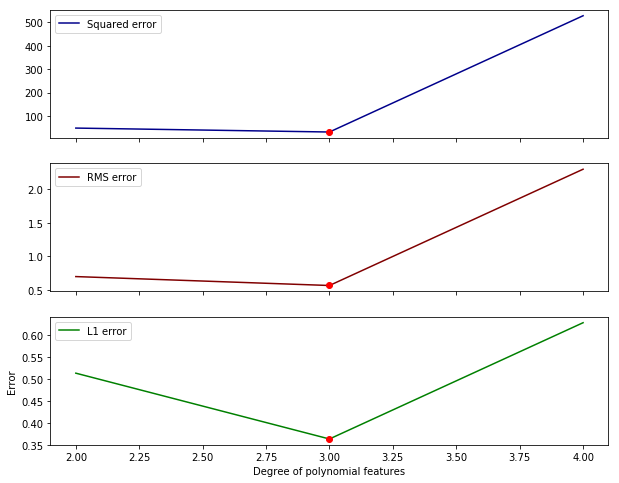

In [207]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression

squared_errs, rms_errs, abs_errs = [], [], []
for degree in range(2, 5):
    polynomial_features = PolynomialFeatures(degree=degree, include_bias=True)
    linear_regression = LinearRegression()
    pipeline = Pipeline([("polynomial_features", polynomial_features),
                         ("linear_regression", linear_regression)])
    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_test)
    unnormalized_test_y = unnormalize(
            y_test, means[kLabel], stds[kLabel])
    unnormalized_predicted_y = unnormalize(
        y_pred, means[kLabel], stds[kLabel])
    squared_err, rms_err, l1_err = compute_error(unnormalized_test_y, 
                                                 unnormalized_predicted_y)

    print('Regression with polynomial features (deg={}) squared error: {}'.
          format(degree, squared_err))
    print('Regression with polynomial features (deg={}) rms error: {}'.
          format(degree, rms_err))
    print('Regression with polynomial features (deg={}) L1 error: {}'.
          format(degree, l1_err))
    
    squared_errs.append(squared_err)
    rms_errs.append(rms_err)
    abs_errs.append(l1_err)
    
f, axarr = plt.subplots(3, sharex=True, figsize=(10, 8))
axarr[0].plot(range(2, 5), squared_errs, color='darkblue', label='Squared error')
axarr[1].plot(range(2, 5), rms_errs, color='maroon', label='RMS error')
axarr[2].plot(range(2, 5), abs_errs, color='green', label='L1 error')

plt.xlabel('Degree of polynomial features')
plt.ylabel('Error')

mins = [(li.index(min(li)), min(li)) for li in [squared_errs, rms_errs, abs_errs]]
for i in range(3):
    axarr[i].legend()
    axarr[i].plot(min_num_neigh + mins[i][0], mins[i][1], 'ro')
    print(mins[i][1])

The perfect value for the degree is 3. For a larger value, the model starts overfitting the data, while for a smaller value it is underfitting.

Also, linear regression with polynomial features of degree 3 represent the best model for predicting longevity.

## Task 2.2. KNN Regression

114.58500252410435
1.0704438449732165
0.8104266018523414


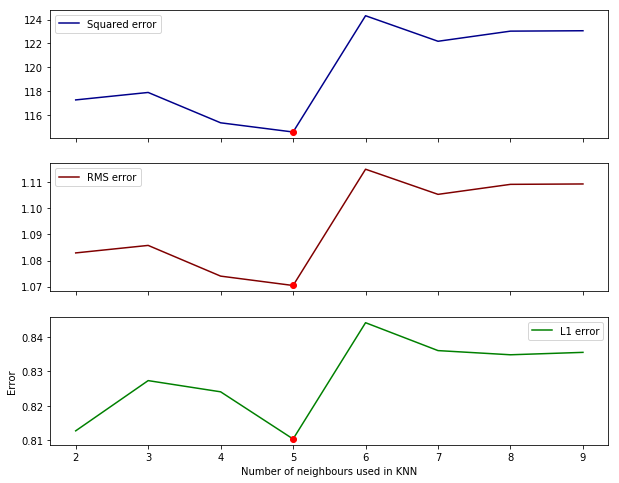

In [208]:
X_train, y_train, X_test, y_test = get_data(data, kLabel, ['Breed Name'], 0.8)

min_num_neigh, max_num_neigh = 2, 10
ks = range(min_num_neigh, max_num_neigh)
squared_errs, rms_errs, abs_errs = [], [], []
for num_neighs in ks:
    knn_regr = KNNRegression(K=num_neighs)
    knn_regr.fit(X_train, y_train)
    y_pred = knn_regr.predict(X_test)

    unnormalized_test_y = unnormalize(
            y_test, means[kLabel], stds[kLabel])
    unnormalized_pred_y = unnormalize(
            y_pred, means[kLabel], stds[kLabel])

    squared_err, rms_err, abs_err = compute_error(unnormalized_test_y, unnormalized_pred_y)
    
    squared_errs.append(squared_err)
    rms_errs.append(rms_err)
    abs_errs.append(abs_err)

f, axarr = plt.subplots(3, sharex=True, figsize=(10, 8))
axarr[0].plot(ks, squared_errs, color='darkblue', label='Squared error')
axarr[1].plot(ks, rms_errs, color='maroon', label='RMS error')
axarr[2].plot(ks, abs_errs, color='green', label='L1 error')

plt.xlabel('Number of neighbours used in KNN')
plt.ylabel('Error')

mins = [(li.index(min(li)), min(li)) for li in [squared_errs, rms_errs, abs_errs]]
for i in range(3):
    axarr[i].legend()
    axarr[i].plot(min_num_neigh + mins[i][0], mins[i][1], 'ro')
    print(mins[i][1])

The best model for predicting longevity was the linear regression model, as it can encapsulate the relationships between the variables better that just weighting the values of the closest neighbours (where the distance is not such a good measure for similarity, as we sum variables that have different scales).